# [E-15] 한국어 대화형 챗봇만들기

# 목차

Step 0. 개념이해

Step 1. 데이터 수집하기

Step 2. 데이터 전처리하기

Step 3. SubwordTextEncoder 사용하기

Step 4. 모델 구성하기

Step 5. 모델 생성하기

Step 6. 모델 컴파일

Step 7. 모델 평가하기

Step 8. 회고

# 개념이해

# 1) Transformer

* 등장이유

어텐션의 문제점은 입력데이터를 순차적으로 처리하기 때문에 병렬처리가 불가능하다. 이는 계산복잡도와 연산시간을 증가시킨다.
또한, 원본언어와 변역된 언어간의 연관여부는 찾을 수 있지만 각 언어가 어떤 관계를 가졌는지는 알 수 없다. 

예) I love dog because it is cute 과 나는 강아지를 좋아한다 왜냐하면 귀엽기 때문이다. 두 문장이 같은 것은 매칭이 가능하지만 it(강아지)가 뭔지는 알 수 없다.  

이를 해결하기 위해 트랜스포머가 나왔다. 

* 정의

-트랜스포머는 Rnn없이 어텐션으로 인코더와 디코더를 만든 구조
- 기존 seq2seq처럼 인코더에서 입력, 디코더에서 출력 하는 구조
- 문장내에서 집중해야할 부분에만 집중해서 문맥을 파악한다. 

file:///home/aiffel-dj54/Desktop/download%20(1).png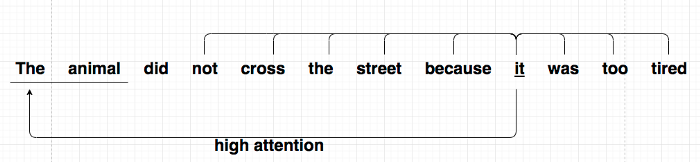

## 구조
* 인코더 - 디코더 구성
* 보통 6개의 인코더 층과 6개의 디코더 층 구조

file:///home/aiffel-dj54/Desktop/download2.png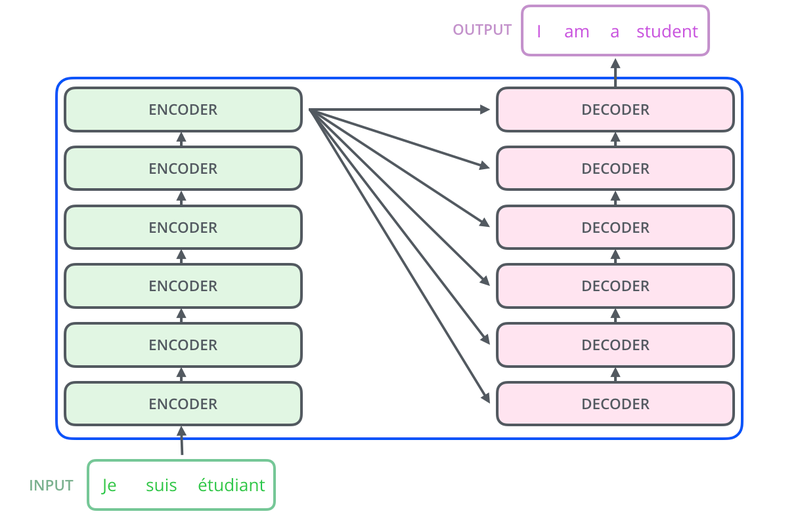


### 세부구조

file:///home/aiffel-dj54/Desktop/download3.png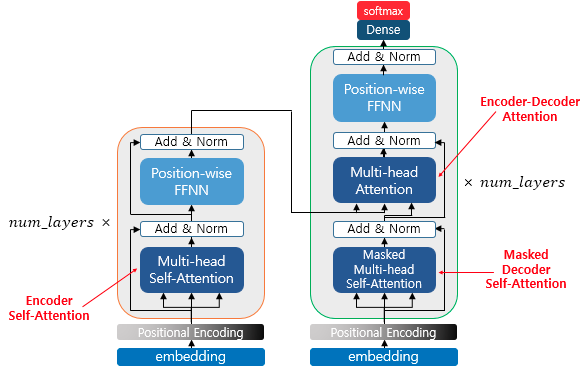

* 인코더는 2개의 sub-layer를 갖고 있다.  Multi-Head Attetion층과 Feed Forward 다.
* 디코더는 3개의 sub-layer를 갖고 있다. 2개는 인코더와 같고 마지막에 인코더 결과와 함께  Multi-Head Attetion을 수행하는 어텐션이 있다.


    인코더 셀프 어텐션 : 인코더의 입력 문장 내 단어간 유사도를 구한다.
    디코더 셀프 어텐션 : 단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어들과의 유사도를 구한다.
    인코더-디코더 어텐션 : 디코더가 잘! 예측하기 위해서 인코더에 입력된 단어들과 유사도를 구한다.


# 2) 더 깊이 이해하기
 트랜스포머 구조를 깊이 이해하기 위해서 아래 개념들을 이해해야 한다.
1. positioning embedding
2. self-attention
3. multi-head attention
4. masked multi-head-attention
5. encoder-decoder attention
6. feed-forward
7. inference - 예측단계

# 2-1) Positional Encoding

어텐션은 인코더의 모든 값이 순서대로 디코더에 입력되었다. 하지만 트랜스포머는 문장을 한번에 입력받는다. 

i love you but but not love him에서 love의 위치를 구분하지 못할 수 있다(같은 값을 가졌기때문). 그래서 위치정보를 갖고 있는 positional encoding값을 더해서 위치에 따라 다른 임베딩 값을 갖도록 한다.

file:///home/aiffel-dj54/Desktop/download4.png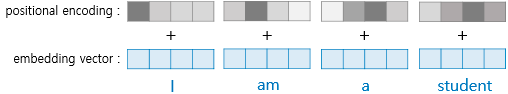


* 포지셔널 인코딩 = 문장벡터 행렬(임베딩 벡터가 모인것) + 덧셈연산

file:///home/aiffel-dj54/Desktop/download5.png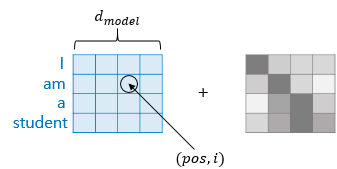

dmodel- 임베딩 벡터의 차원

pos - 임베딩 벡터의 위치

i- 임베딩 벡터 내의 차원의 인덱스

# 2-2) self-attention
= 한 문장내의 단어간 유사도를 구하는 것

 I love dog because it is cute 이란 문장에서 it이 dog와 연관되있을 확률이 높다는 것을 유사도를 구해서 알아낸다.
 
* 유사도는 어떻게 구하지?
= 스케일드 닷 프로덕트 어텐션
* 특정값을 분모로 나눠주는 방식으로 유사도를 구해서 스케일드 닷 프로덕트 어텐션이라고 한다.

간단하게 어텐션 함수를 정리하고 가자

어텐션 함수는 q에 대해서 모든 k와의 유사도를 구하고 이것을 v에 반영한다.
반영된 값을 모두 더하면 어텐션 값이 나온다. 

file:///home/aiffel-dj54/Desktop/download6.png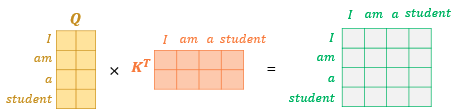

* i(q)를 i, am, a, student(k)에 내적해서 벡터간 유사도(attention score)를 구한다. 
* 초록색 행렬 = 각 단어 벡터의 유사도가 기록된 행렬

file:///home/aiffel-dj54/Desktop/download7.png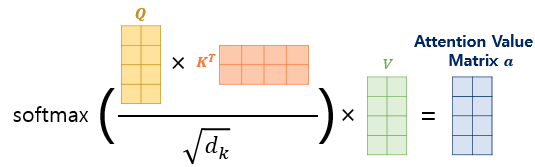

* attention score를 특정값으로 나눠주고 소프트맥스를 사용해서 0-1값으로 만든다. = 현재단어(q)가 k와 얼마나 연관이 있는지 나타낸 확률 
* 여기에 현재 문장행렬(v)을 곱하면 attention value가 나온다. 
* q와 유사한 v일수록 더 높은 값을 가진다(더 진하다) -> 중요한 정보에 더 관심을 두게 된다!

# 2-3) multi-head attention
= 셀프어텐션을 num_head개의 관점으로 보고 합친것이다.

file:///home/aiffel-dj54/Desktop/download8.png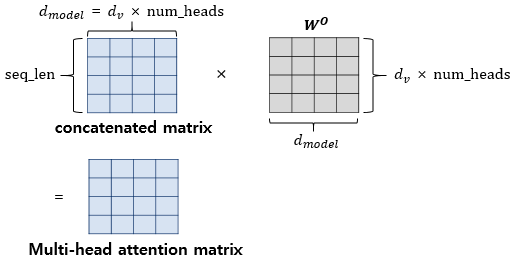

문장행렬을 num_heads의 수만큼 쪼개서 각 어텐션을 수행하고 이를 다시 어텐션 행렬로 합친다. 

동일한 q,k,v에 각기 다른 w를 곱해준다. 

file:///home/aiffel-dj54/Desktop/download9.png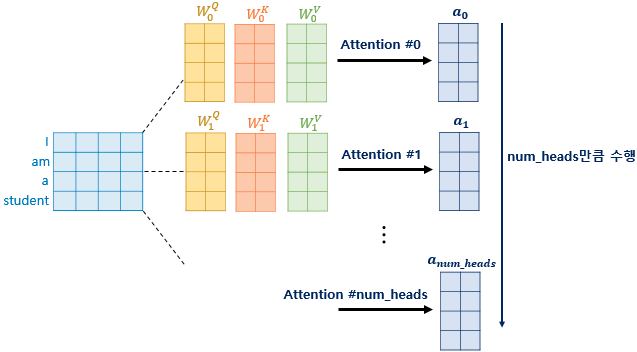

병렬로 어텐션을 수행하기에 다양한 관점으로 문장을 볼 수 있다. 이는 놓칠 수 있던 정보를 얻을 수 있다는 장점이 있다.



# 2-4) masked multi-head-attention
= 인코더의 셀프어텐션은 padding masking을 선택적으로 사용하지만, 디코더의 셀프어텐션은 look_ahead_mask를 사용한다. 
* 어텐션 값을 만들고 masking을 한 후 softmax값을 취한다.

file:///home/aiffel-dj54/Desktop/download10.png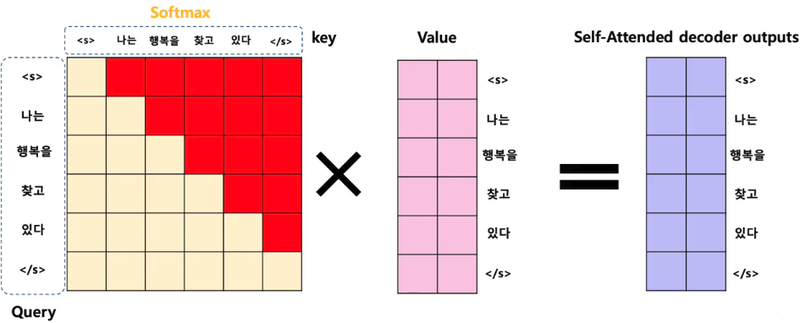

디코더는 이전 단어들로 부터 다음 단어를 예측하고 싶기 때문에 과거와 예측할 벡터에 집중해야한다. 그래서 다음에 나올 단어를 가리는 기법을 사용한다. 


# 2-5) encoder-decoder attention

* 셀프어텐션 위에 multi HA 부분 

file:///home/aiffel-dj54/Desktop/download11.png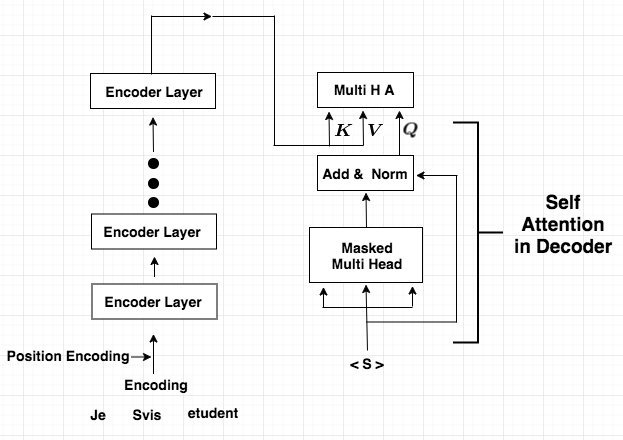


Q- 이전 디코더의 예측단어

K- 인코더의 output

V- 인코더의 output

* 인코더의 output이 영어고 디코더가 한글이라면 
* 이 과정에서 한글과 영어 문장을 매칭한다.
* 디코더의 단어와 인코더문장간 단어의 유사도를 구한다.
* 영어문장(인코더)과의 유사도를 구한 단어(한글)가 나온다. 

# 2-6) feed-forward

멀티헤드 어텐션에서 각 head가 자신의 관점으로 문장을 어텐션하면 각 관점에 따라 집중도가 치우쳐진다. 
feed-forward는 각 head가 만든 self-attention이 치우치지 않게 균등하게 섞는 역할을 한다. 

* 커널사이즈가 1인 두개의 컨볼루션을 통과하면 결과를 얻을 수 있다고 한다.


file:///home/aiffel-dj54/Desktop/download12.png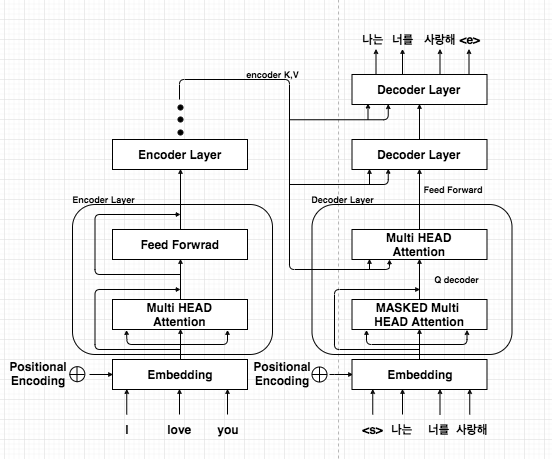

* feed-forward를 통과 한 후 softmax로 0-1사이 값으로 만든 후 output을 낸다
* output은 y_pred로 다음에 올거라고 예측한 값이다. 
* 이를 실제 값과 비교해서 오차를 줄여간다.

# 2-7) inference - 예측단계

* 예측단계 구조는 그림으로 살펴보자

file:///home/aiffel-dj54/Desktop/download13.png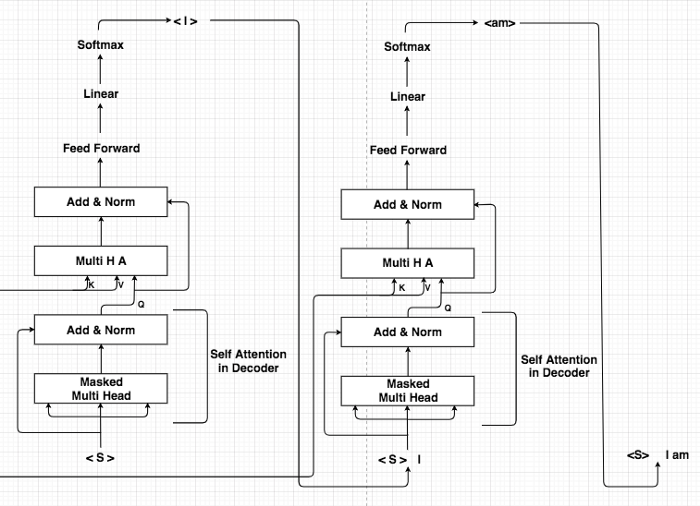

* 새로운 입력 문장을 훈련과 동일한 전처리를 거친다.  
* 인코더값과 이전의 디코더 값의 어텐션을 구해서 다음 단어를 예측한다. 
* 예측할때 인코더로 들어오는 문장은 알고 있다.
* 하지만, 디코더는 모른다. 그래서 <Start_token>을 추가한다. 
* <end_token>으로 문장의 최대길이에 도달하면 종료한다.

참고 블로그

* https://medium.com/platfarm/%EC%96%B4%ED%85%90%EC%85%98-%EB%A9%94%EC%BB%A4%EB%8B%88%EC%A6%98%EA%B3%BC-transfomer-self-attention-842498fd3225
* https://catsirup.github.io/ai/2020/04/07/transformer.html
* http://docs.likejazz.com/bert/#position-wise-feed-forward-network

# Step 1. 데이터 수집하기

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print("슝=3")

슝=3


In [2]:
data_filepath = os.getenv('HOME')+'/aiffel/aiffel_exp_data/songys_chatbot/ChatbotData .csv' 
data = pd.read_csv(data_filepath) 
print(type(data))
data.head()

<class 'pandas.core.frame.DataFrame'>


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [3]:
data.tail()

,Q,A,label
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2
11822,힘들어서 결혼할까봐,도피성 결혼은 하지 않길 바라요.,2


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [5]:
data.shape #11823행 3열 

(11823, 3)

In [6]:
data.columns #label은 사용안함

Index(['Q', 'A', 'label'], dtype='object')

# Step 2. 데이터 전처리하기(cleaning)
* 결측치 제거, 중복데이터 제거, 구둣점제거, 불용어제거

* 정규화, 토큰화, 정규화

## 정제&정규화

In [7]:
print('컬럼별 결측치 개수')
len(data) - data.count() #Q = INPUT, A = OUTPUT

컬럼별 결측치 개수


Q        0
A        0
label    0
dtype: int64

In [8]:
data.isnull() #각행에 결측치가 있으면 true 없으면 false

,Q,A,label
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
11818,False,False,False
11819,False,False,False
11820,False,False,False
11821,False,False,False


In [9]:
data.duplicated() #중복데이터 여부

0        False
1        False
2        False
3        False
4        False
         ...  
11818    False
11819    False
11820    False
11821    False
11822    False
Length: 11823, dtype: bool

In [10]:
questions = data['Q']
answers = data['A']

In [11]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 8000
print(MAX_SAMPLES)

8000


정규표현식 모듈함수 = re.sub() 문자열에서 정규표현식과 일치하는 부분을 다른 문자열로 대체합니다.

In [12]:
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence) #구두점은 \1칸 공백을 준다.
  sentence = sentence.strip()
  return sentence
print("슝=3")

슝=3


In [13]:
text="한국!...핳안녕"
result=preprocess_sentence(text)
print(result)

한국 !  .  .  . 핳안녕


In [14]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
#zip 함수 동일한 개수인 자료형을 묶어주는 함수
# # 
# def load_conversations():
#     inputs, outputs = [], []
#     for q,a in zip(data['Q'],data['A']):
#         inputs.append(preprocess_sentence(q))
#         outputs.append(preprocess_sentence(a))
                
#         if len(inputs) >= MAX_SAMPLES:
#             return inputs, outputs
# #             print(inputs,outputs)
#     return inputs, outputs
# print("슝=3")

In [15]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
# questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [16]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요.


# Step 3. SubwordTextEncoder 사용하기
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

## 단어장(Vocabulary) 만들기

In [17]:
# 질문과 답변 데이터에서 단어장 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

슝=3 


In [18]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


In [19]:
#단어장의 크기가 0-8125번이라는 의미
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8361]
END_TOKEN의 번호 : [8362]


In [20]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8363


## 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

In [21]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.(단어->정수)
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5824, 602, 2498, 4170]
정수 인코딩 후의 21번째 답변 샘플: [2683, 7666, 6, 6375, 92, 8151]


In [22]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [23]:
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [24]:
questions, answers = tokenize_and_filter(questions, answers) #input,output으로 질문과 응답을 넣는다
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8363
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


## 교사 강요(Teacher Forcing) 사용하기

In [25]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


# Step 4. 모델 구성하기

## 모델 정의 및 학습하기

### 4-1)  포지셔널 인코딩 레이어

In [26]:

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
    # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
print("슝=3")

슝=3


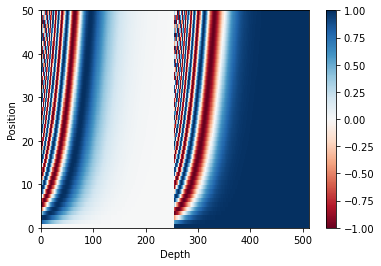

In [27]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### 4-2)어텐션 정의 

닷-프로덕트 어텐션이 q*k의 유사도를 구하는 방법이였다면,

scaled_dot_product attention은 유사도를 특정값을 분모로 나눠주는 방식으로 유사도를 구한다. 


In [28]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True) #어텐션 가중치 계산 

  # scale matmul_qk # Q와 K를 곱해서 유사도를 구한다.
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth) #유사도를 특정값(차원)으로 나눠준다.

  # add the mask to zero out padding tokens
    if mask is not None:logits += (mask * -1e9)

  # 유사도를 0-1값으로 구하려고 softmax를 사용한다.
    attention_weights = tf.nn.softmax(logits, axis=-1)
  # 유사도와 v를 곱한다 = 어텐션 값
    output = tf.matmul(attention_weights, value)

    return output
print("슝=3")

슝=3


In [29]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

        #d_model을 num_head 개로 쪼갠다 
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

    # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다.
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다.
        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
        outputs = self.dense(concat_attention)

        return outputs
print("슝=3")

슝=3


### 4-3)마스킹
* 패딩 마스킹-짧은 문장에 0을 채워서 문장 길이를 맞춰주는 방법
* 0의 위치를 1로 체크해준다

In [30]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [31]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


* 룩 어헤드 마스킹

트랜스포머는 디코더는 현재 단어를 예측하고자 한다. 이때 문장행렬이 한번에 들어오면 위치에 집중해서 단어를 예측할 수 없기에 다음에 나올 단어는 가리는 기법을 사용한다.

In [32]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


In [33]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [34]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### 4-4)인코더 하나의 레이어를 함수로 구현.

In [35]:
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

	# 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


###  인코더 층을 쌓아서 최종적인 인코더 만들기 
* 인코더층을 임베딩과 포지셔널 인코딩을 연결하고

In [36]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

	# 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),)([outputs, padding_mask])
        
        return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


### 4-5)디코더 하나의 레이어를 함수로 구현

In [37]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask})

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
        'query': attention1,
        'key': enc_outputs,
        'value': enc_outputs,
        'mask': padding_mask})

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
                          outputs=outputs,name=name)
print("슝=3")

슝=3


### 디코더 층을 쌓아 디코더 만들기

In [38]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

	# 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
	# 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

	# 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

	# Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)
print("슝=3")

슝=3


### 4-6)트랜스포머 함수 정의

In [39]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

	# 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

  # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

  # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


# Step 5. 모델 생성

In [40]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Model)                 (None, None, 256)    2668032     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

## 5-2. 손실 함수(Loss function)

In [41]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")


슝=3


## 5-3. 커스텀된 학습률(Learning rate)

In [42]:

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

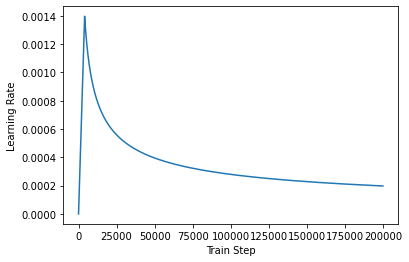

In [43]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Step 6. 모델 컴파일

In [44]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


# 훈련하기

In [45]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Train for 185 steps
Epoch 1/20
185/185 [==============================] - 15s 84ms/step - loss: 1.4514 - accuracy: 0.0342
Epoch 2/20
185/185 [==============================] - 11s 62ms/step - loss: 1.1841 - accuracy: 0.0494
Epoch 3/20
185/185 [==============================] - 12s 66ms/step - loss: 1.0076 - accuracy: 0.0507
Epoch 4/20
185/185 [==============================] - 12s 62ms/step - loss: 0.9302 - accuracy: 0.0547
Epoch 5/20
185/185 [==============================] - 12s 65ms/step - loss: 0.8716 - accuracy: 0.0575
Epoch 6/20
185/185 [==============================] - 12s 64ms/step - loss: 0.8110 - accuracy: 0.0619
Epoch 7/20
185/185 [==============================] - 12s 63ms/step - loss: 0.7445 - accuracy: 0.0679
Epoch 8/20
185/185 [==============================] - 11s 61ms/step - loss: 0.6687 - accuracy: 0.0758
Epoch 9/20
185/185 [==============================] - 12s 63ms/step - loss: 0.5868 - accuracy: 0.0848
Epoch 10/20
185/185 [==============================] - 12s 62m

# Step 7. 모델 평가하기

In [46]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


### 임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수를 만듭니다.

In [47]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


In [48]:
sentence_generation("고기 먹자") #오? 재치보소

입력 : 고기 먹자
출력 : 저기압에는 고기앞이죠.


'저기압에는 고기앞이죠.'

In [49]:
sentence_generation("왜 그래") #약올리는거 같은데...?

입력 : 왜 그래
출력 : 쉬운 결정은 아니었을거라 생각해요.


'쉬운 결정은 아니었을거라 생각해요.'

In [50]:
sentence_generation("너 성별이 뭐야?") 

입력 : 너 성별이 뭐야?
출력 : 저는 위로봇입니다.


'저는 위로봇입니다.'

In [51]:
sentence_generation("내일 날씨 좋아?") # 단호박이네..

입력 : 내일 날씨 좋아?
출력 : 날씨 어플에 물어보세요.


'날씨 어플에 물어보세요.'

In [52]:
sentence_generation("너무해!!!") #ㅋㅋㅋㅋㅋㅋㅋ

입력 : 너무해!!!
출력 : 그런 사람 만나길 바랄게요.


'그런 사람 만나길 바랄게요.'

# 루브릭

1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.
	공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.


2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.
	구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.


3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.
	한국어 입력문장에 그럴듯한 한국어로 답변을 리턴하였다.

# 회고
* 처음에 트랜스포머 개념이 너무 복잡하고 이해가 안돼서 팀원들이랑 하루종일 트랜스포머 얘기만 했다.

전체적인 구조를 이해하는데 오랜 시간이 걸렸다. 

rnn,lstm은 인코더의 컨텍스트 벡터를 디코더의 인풋으로 넣었는데 트랜스포머는 인코더와 디코더에 같은 데이터를 따로 넣는 개념이 새로웠다. 


* 셀프 어텐션을 보면서 요약문 프로젝트할때 어텐션 개념을 배웠지만 얕게 알고 있었다는걸 깨닫고 다시 공부했다.

닷-프로덕트 어텐션부터 공부해서 스케익드 닷 프로덕트 어텐션을 이해했다. 


* q,k,v의 역할과 k,v의 차이가 너무 헷갈렸다. 아직도 명확하게 k,v가 어떤점이 다른지 설명은 못하겠다...간략한 차이만 이해하고 있다.

k,v는 값은 다르지만 위치는 같은 값(?)


* 셀프어텐션은 이해가 됐는데 멀티헤드 어텐션이 한번에 이해가 안됐었다..


* 아직 더 깊이 알아야할 부분이 많은거 같다..끝이없다


* 그래도 참고한 블로그를 통해서 전체적인 구조와 함수의 역할을 이해한거 같아서 보람차다.